Given a collection of example MIDI files (I'm going to stick to *monophonic* due to my final playback restrictions), train a network to predict the probability of the next note conditioned on the current note history.

NBD: This might not *technically* be an autoregression model, I should check that out...

In [221]:
%load_ext autoreload
%autoreload 2
import data_loading
import IPython
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from reverse_pianoroll import piano_roll_to_pretty_midi
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
dataset_train = data_loading.NotesGenerationDataset("data/training")
loader_train = data.DataLoader(
    dataset_train, batch_size=min(len(dataset_valid), 8),
    shuffle=True, drop_last=True)
print("Loaded {} songs as training dataset with max length {}.".format(
    len(dataset_train), dataset_train.longest_sequence_length))
dataset_valid = data_loading.NotesGenerationDataset("data/valid")
loader_valid = data.DataLoader(
    dataset_valid, batch_size=min(len(dataset_valid), 8),
    shuffle=True, drop_last=True)
print("Loaded {} songs as valid dataset with max length {}.".format(
    len(dataset_valid), dataset_valid.longest_sequence_length))

Loaded 53 songs as training dataset with max length 2256.
Loaded 1 songs as valid dataset with max length 720.


(48, 100)
(96, 102)


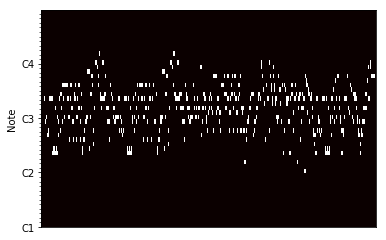

In [229]:
# Draw the first validation sample
X_val = next(iter(loader_valid))
librosa.display.specshow(X_val[0][0, :, :].numpy().T, y_axis='cqt_note', cmap=plt.cm.hot);

audio_data = piano_roll_to_pretty_midi(
    X_val[0][0, 0:100, :].numpy().T, fs=120/16, base_note=dataset_train.lowest_note_num).synthesize()
IPython.display.Audio(audio_data, rate=44100)

In [230]:
# Starting point for me: RNN from
# https://github.com/SudharshanShanmugasundaram/Music-Generation/blob/master/notebooks/musicGeneration.ipynb

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):    
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [231]:
model = RNN(input_size=dataset_train.num_notes,
            hidden_size=512,
            num_classes=dataset_train.num_notes).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()

In [232]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in loader_valid:
        post_processed_batch_tuple = data_loading.post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)
validate(model)

2.0367688634691324e-05

In [233]:
def train_model(model, lr, epochs_number=2, wd=0.0, clip=1.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for batch in loader_train:
            post_processed_batch_tuple = data_loading.post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(loader_train)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [235]:
model = RNN(input_size=dataset_train.num_notes,
            hidden_size=512,
            num_classes=dataset_train.num_notes).cuda()
model = model.cuda()
best_val_loss = train_model(model, 1e-4, epochs_number=10)

Training Loss: Epoch: 0 : 0.13557822299453448
Validation Loss: Epoch: 0 : 1.4241024115125092e-05

Training Loss: Epoch: 1 : 0.0939562607486293
Validation Loss: Epoch: 1 : 4.75332299184974e-06

Training Loss: Epoch: 2 : 0.0722307523466506
Validation Loss: Epoch: 2 : 3.1381381049381074e-06

Training Loss: Epoch: 3 : 0.059257881399595515
Validation Loss: Epoch: 3 : 3.880296335357196e-06

Training Loss: Epoch: 4 : 0.05483825068991139
Validation Loss: Epoch: 4 : 3.669028476451498e-06

Training Loss: Epoch: 5 : 0.05311547233810965
Validation Loss: Epoch: 5 : 4.177358915718697e-06

Training Loss: Epoch: 6 : 0.04838267699727472
Validation Loss: Epoch: 6 : 4.472851824829771e-06

Training Loss: Epoch: 7 : 0.054776044808468725
Validation Loss: Epoch: 7 : 4.583356209840677e-06

Training Loss: Epoch: 8 : 0.04253670263965175
Validation Loss: Epoch: 8 : 3.6521370239242136e-06

Training Loss: Epoch: 9 : 0.04128890554859953
Validation Loss: Epoch: 9 : 1.1343532038753893e-05



In [236]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):
    rnn.eval()
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, dataset_train.num_notes)
        current_sequence_input[0, 0, np.random.randint(0, dataset_train.num_notes)] = 1
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

(48, 201)
(96, 203)


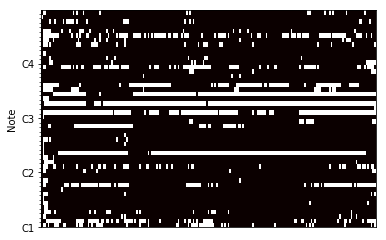

In [240]:
# model.load_state_dict('music_model_padfront_regularized.pth')
sample = sample_from_piano_rnn(model, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
librosa.display.specshow(sample, y_axis='cqt_note', cmap=plt.cm.hot)

from reverse_pianoroll import piano_roll_to_pretty_midi
audio_data = piano_roll_to_pretty_midi(sample, fs=120/16, base_note=dataset_train.lowest_note_num).synthesize()
IPython.display.Audio(audio_data, rate=44100)